# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_test.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

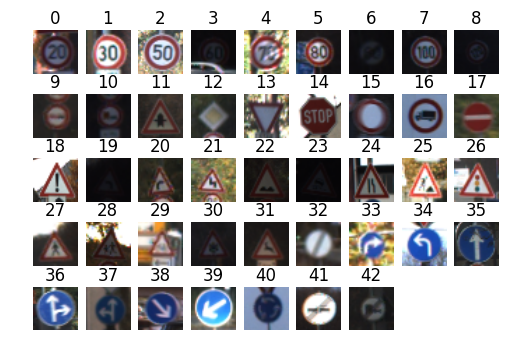

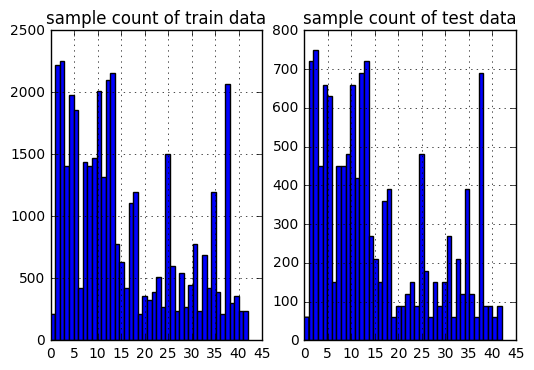

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.figure()
for i in range(0, n_classes):
    plt.subplot(5, 9, i+1)
    idx = [y_test == i]
    img = X_test[idx][0]
    plt.imshow(img)
    plt.title(str(i))
    plt.axis('off')
plt.show()



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
from tqdm import tqdm
import cv2
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# convert RGB to Gray, apply histogram equalization, data normalization
X_gray = np.array([])
# Progress bar
batches_pbar = tqdm(range(len(y)), desc='Percent ', unit='images')

for i in batches_pbar:
    img = X[i]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    # opencv's imread return BGR, but here is RGB
    gray = cv2.equalizeHist(gray)    # equalize the histogram
    gray = (gray-128)/128 # normalization
    gray = gray.reshape(1,32,32,1)
    if i==0:
        X_gray = gray
    else:
        X_gray = np.append(X_gray, gray, axis=0)
    
print(X_gray.shape)


Percent : 100%|██████████| 51839/51839 [56:54<00:00,  7.96images/s]

(51839, 32, 32, 1)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

1) Convert RGB to Gray and in order to make model insensitive to color variations

2) Apply histogram equalization to mitigate the influence caused by illumination changes.

3) Data normalization to make the problem well conditioned, which is helpful to initialization and learning convergence.

In [12]:
### Generate additional data (OPTIONAL!).
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# data split with shuffle
from sklearn.model_selection import train_test_split
import os
X_tr_val,  X_ts,  y_tr_val,  y_ts = train_test_split(
    X_gray,
    y,
    test_size=0.1,
    random_state=832289)
X_tr,  X_val,  y_tr,  y_val = train_test_split(
    X_tr_val,
    y_tr_val,
    test_size=0.1,
    random_state=832289)

print('Training features and labels randomized and split.')

### Generate additional data (OPTIONAL!)
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
    # apply operations
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    if brightness == 1:
      img = augment_brightness_camera_images(img)
    return img

def augment_data(X, y):
    n_classes = len(np.unique(y))
    avg_sample_num = len(y)/n_classes
    for i in range(0, n_classes):
        idx = np.argwhere(y==i)
        num = len(idx)
        cnt = num
        while cnt < avg_sample_num:
            img = X[idx[cnt%num]].reshape(32, 32, 1)
            img = transform_image(img,20,10,5,brightness=0).reshape(1,32, 32, 1)
            X = np.append(X, img, axis=0)
            y = np.append(y, np.array(i))
            cnt += 1
    return X, y

X_tr,   y_tr = augment_data(X_tr, y_tr)
X_val,  y_val = augment_data(X_val, y_val)
X_ts,   y_ts = augment_data(X_ts, y_ts)

Training features and labels randomized and split.


### Save Checkpoint

In [13]:
# Save the data for easy access
pickle_file = 'sign.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('sign.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_tr,
                    'train_labels': y_tr,
                    'valid_dataset': X_val,
                    'valid_labels': y_val,
                    'test_dataset': X_ts,
                    'test_labels': y_ts,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


### Load Checkpoint

In [14]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'sign.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['train_dataset']
  y_train = pickle_data['train_labels']
  X_validation = pickle_data['valid_dataset']
  y_validation = pickle_data['valid_labels']
  X_test = pickle_data['test_dataset']
  y_test = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
1) I first shuffle the dataset, and divid the dataset in to 1/10 for testing stage data and 9/10 for training stage data. Then, during traing stage, I again divide the training stage data into 1/10 for validation and 9/10 for training.

2) I use Rotation, Translation, Shear operations to generate data, since the data are very unbalanced among different classes. In the new dataset, each class has at least 1205 images.

In [116]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name='conv1_W')    # the filters' weights
    conv1_b = tf.Variable(tf.zeros(6), name='conv1_b')    # the filters' biases
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name='conv2_W')    # the filters' weights
    conv2_b = tf.Variable(tf.zeros(16), name='conv2_b')    # the filters' biases
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2= tf.nn.max_pool(conv2, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(120), name='fc1_b')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name='fc2_W')
    fc2_b = tf.Variable(tf.zeros(84), name='fc2_b')
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='fc3_W')
    fc3_b = tf.Variable(tf.zeros(43))
    logits   = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I use the classical LeNet which is a convolutional network containing five layers:  two conv layers (5x5x6 and 5x5x16), three fully-connect layers (400x120, 120x84 and 84x43). I use ReLU as activation function.

In [117]:
### Train your model here.
### ----------- Definition -----------
import tensorflow as tf
from sklearn.utils import shuffle

tf.reset_default_graph()

with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, 43)

    EPOCHS = 30
    BATCH_SIZE = 128
    rate = 0.0005

    logits = LeNet(x)
    softmax_operation = tf.nn.softmax(logits)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

    predict_operation = tf.argmax(logits, 1)
    groundtruth_operation = tf.argmax(one_hot_y, 1)
    correct_prediction = tf.equal(predict_operation, groundtruth_operation)
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()
    
    init = tf.initialize_all_variables()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# set allow_soft_placement =True to Making tf.Variable ignore tf.device(), otherwise there will be some gpu error
config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)

In [118]:
### ----------- Traininig -----------
with tf.Session(config=config) as sess:
    sess.run(init)
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet2')    # `save` method will call `export_meta_graph` implicitly.
    print("Model saved")
######################################################


Training...
EPOCH 1 ...
Validation Accuracy = 0.322

EPOCH 2 ...
Validation Accuracy = 0.435

EPOCH 3 ...
Validation Accuracy = 0.505

EPOCH 4 ...
Validation Accuracy = 0.538

EPOCH 5 ...
Validation Accuracy = 0.589

EPOCH 6 ...
Validation Accuracy = 0.606

EPOCH 7 ...
Validation Accuracy = 0.632

EPOCH 8 ...
Validation Accuracy = 0.661

EPOCH 9 ...
Validation Accuracy = 0.676

EPOCH 10 ...
Validation Accuracy = 0.679

EPOCH 11 ...
Validation Accuracy = 0.685

EPOCH 12 ...
Validation Accuracy = 0.709

EPOCH 13 ...
Validation Accuracy = 0.707

EPOCH 14 ...
Validation Accuracy = 0.722

EPOCH 15 ...
Validation Accuracy = 0.714

EPOCH 16 ...
Validation Accuracy = 0.732

EPOCH 17 ...
Validation Accuracy = 0.732

EPOCH 18 ...
Validation Accuracy = 0.734

EPOCH 19 ...
Validation Accuracy = 0.727

EPOCH 20 ...
Validation Accuracy = 0.749

EPOCH 21 ...
Validation Accuracy = 0.749

EPOCH 22 ...
Validation Accuracy = 0.755

EPOCH 23 ...
Validation Accuracy = 0.760

EPOCH 24 ...
Validation Accurac

In [143]:
### ----------- Testing -----------
print("Testing...")
import sklearn as sk
import numpy as np
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, './lenet2')
    y_true = sess.run(groundtruth_operation, feed_dict={x: X_test, y: y_test})
    y_pred = sess.run(predict_operation, feed_dict={x: X_test, y: y_test})
    acc = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test})
    print ("Precision: " + str(sk.metrics.precision_score(y_true, y_pred, average='weighted')))
    print ("Recall: " + str(sk.metrics.recall_score(y_true, y_pred, average='weighted')))
    print ("f1_score: " + str(sk.metrics.f1_score(y_true, y_pred, average='weighted')))
    np.set_printoptions(threshold=9999999)  #print all  
    print ("confusion_matrix")
    cm = sk.metrics.confusion_matrix(y_true, y_pred)
    print (str(cm))
#     n_classes = len(np.unique(y_test))
#     for i in range(n_classes):
#         print("--------------- Testing class " + str(i) + ' -------------')
#         idx = np.argwhere(y_test==i).reshape(-1)
#         y_true = sess.run(groundtruth_operation, feed_dict={x: X_test[idx], y: y_test[idx]})
#         y_pred = sess.run(predict_operation, feed_dict={x: X_test[idx], y: y_test[idx]})
#         acc = sess.run(accuracy_operation, feed_dict={x: X_test[idx], y: y_test[idx]})
#         print ("Precision: " + str(sk.metrics.precision_score(y_true, y_pred, average='micro')))
#         print ("Recall: " + str(sk.metrics.recall_score(y_true, y_pred, average='micro')))
#         print ("f1_score: " + str(sk.metrics.f1_score(y_true, y_pred, average='micro')))
#         print ("confusion_matrix")
#         print (str(sk.metrics.confusion_matrix(y_true, y_pred)))

Testing...
Precision: 0.771263182499
Recall: 0.767255216693
f1_score: 0.765292245154
confusion_matrix
[[ 16  12   1   1   0   0   0   1   1   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  2 241  22   4  15   5   0   5   4   0   2   0   0   0   0   2   0   0
    0   0   1   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
    1   1   0   2   3   0   0]
 [  1  24 176   6  11  24   0  28   5   0   3   0   1   0   0   1   0   0
    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   1
    0   0   1   3   2   0   0]
 [  1   3   6 151   0  12   0   7   1   2   1   0   2   0   0   4   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0   1   1   1   0   0]
 [  0  15   2   1 214   2   0   5  10   0   0   0   2   0   1   4   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   1   2   0   0]
 [ 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I use Adam optimizer, and the hyperparameters are set as following,
    EPOCHS = 100
    BATCH_SIZE = 128
    rate = 0.001

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

5 steps:

1) Data preprocessing: RGB-->GRAY (color insensitive), Illumination equalization (illumination robust), Data augmentation (mitigate data inbalanced)

2) CNN model choose: LeNet containing 5 layers (simple and efficient)

3) Optimizer choose: Adam, simple and efficient with less hyperparameters

4) mini-batch training with many epoches, and validation

5) Testing

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

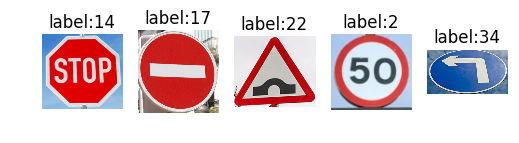

In [60]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
rootDir = './sign-imgs'
img_num = len(os.listdir(rootDir))
X_web = np.array([])
y_web = np.array([])
for idx, file in enumerate(os.listdir(rootDir)): 
        path = os.path.join(rootDir, file) 
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # opencv's imread return BGR, but here is RGB
        gray = cv2.resize(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (32, 32))
        gray = cv2.equalizeHist(gray)    # equalize the histogram
        gray = (gray-128)/128 # normalization
        label = file.split('.')[0]
        if idx==0:
            X_web = gray.reshape(1, 32, 32, 1)
            y_web = np.array([int(label)])
        else:
            X_web = np.append(X_web, gray.reshape(1, 32, 32, 1), axis=0)
            y_web = np.append(y_web, [int(label)])
        plt.subplot(1, img_num, idx+1)
        plt.imshow(img)
        plt.title('label:' + label)
        plt.axis('off')
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The fifth image suffers a serious distorition which makes classification difficult.

In [120]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, './lenet2')
    y_perd = sess.run(predict_operation, feed_dict={x: X_web, y: y_web})
    print(y_perd)

[14 39 22 40 29]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The accuracy on captured pictures is 40%, which is lower than 77%, the accuracy on the testing dataset. Since here are only 5 captured traffic sign images, the result is not so convinced in statistics.

topk-values:[ 0.88151801  0.05765568  0.02303354  0.01741686  0.00843359]            topk-indices:[14 33 35 40 34]
topk-values:[ 0.43821025  0.38568497  0.04129887  0.03949535  0.0309086 ]            topk-indices:[39 17 16 12 40]
topk-values:[ 0.82834095  0.14699234  0.01162617  0.00642098  0.0031538 ]            topk-indices:[22 30 29 23 20]
topk-values:[ 0.49315697  0.18695916  0.16026495  0.06987319  0.047111  ]            topk-indices:[40 33 14 36 10]
topk-values:[ 0.44784877  0.24639477  0.08906729  0.08750226  0.04146915]            topk-indices:[29 20 22 28 15]


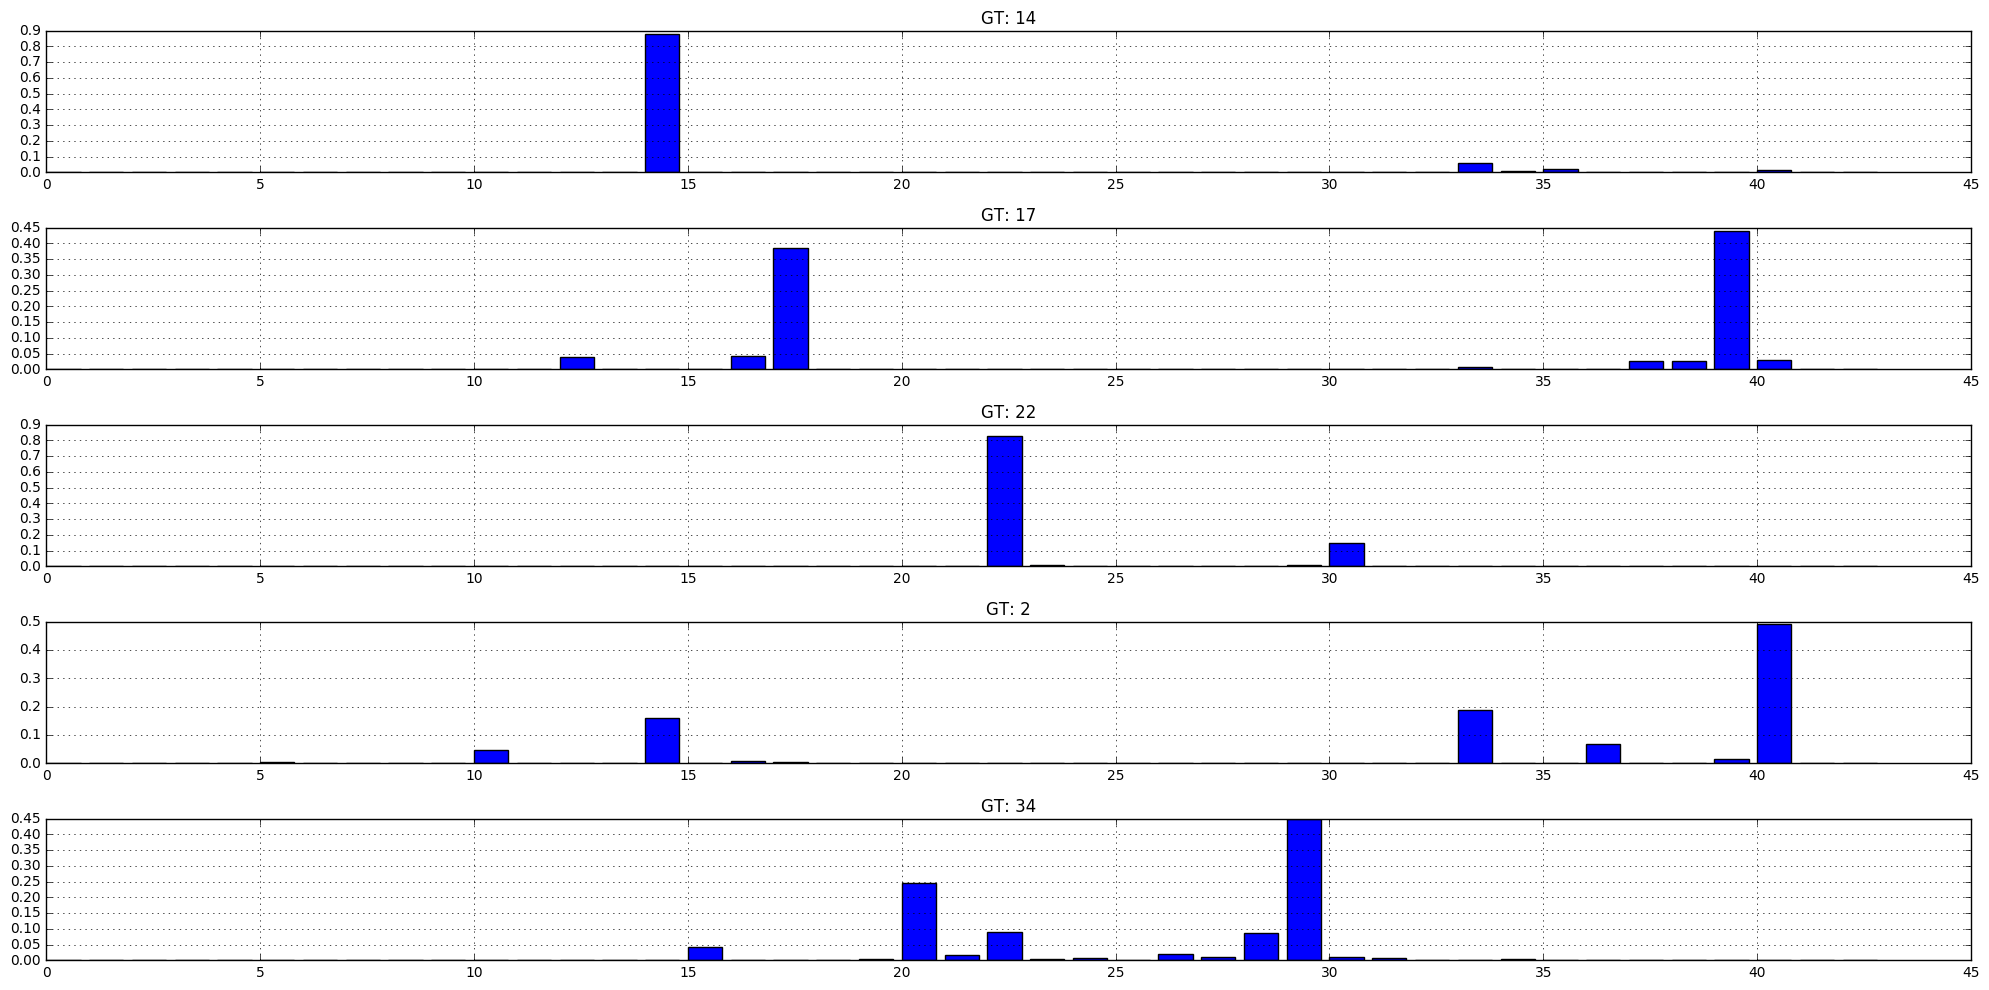

In [135]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, './lenet2')
    softmax_prob = sess.run(softmax_operation, feed_dict={x: X_web, y: y_web})
    topk = sess.run(tf.nn.top_k(softmax_prob, k=5))
    plt.figure(figsize=(20,10))
    n_classes = len(softmax_prob[0])
    for i in range(len(softmax_prob)):
        plt.subplot(len(softmax_prob), 1, i+1)
#         plt.hist(softmax_prob[i], bins=n_classes)
        plt.bar(np.arange(n_classes), softmax_prob[i])
        plt.title('GT: ' + str(y_web[i]))
        plt.grid(True)
        plt.tight_layout()
        print('topk-values:' + str(topk.values[i]) + '            topk-indices:' + str(topk.indices[i]))
    plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The model is certain of 14, 22 classes. For 17, 2, 34 classes, it is uncertain. Besides, for 17 class, the model was incorrect in its initial prediction but is correct within top-k.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.